In [1]:
########################################################
#################### IMPORT MODULES ####################
########################################################

import numpy as np ## for working with arrays
import matplotlib.pyplot as plt ## for plotting
%matplotlib inline
import math ## for math
from scipy.interpolate import interp1d ## for interpolating points
import pandas as pd # for dataframe capabilities
import seaborn as sns # for hue and other plotting capabilities

# for reading in lists of files in folders 
from os import listdir 
from os.path import isfile, join

# for principal component analysis
from sklearn.decomposition import PCA 

# for Kruskal-Wallis test
from scipy import stats

## for linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.metrics import confusion_matrix

# for Spearman Rank correlation
from scipy.stats import spearmanr

## suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
##########################################################
#################### DEFINE FUNCTIONS ####################
##########################################################

## function to find indices of a character in a string

def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

# define a function to return equally spaced, interpolated points for a given polyline
# inputs: arrays of x and y values for a polyline, number of points to interpolate
# ouputs: interpolated points along the polyline, inclusive of start and end points, as arrays

def interpolation(x, y, number): 

    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

# define a function to find corresponding index positions of landmarks in the trace file
# and return a trace file at higher resolution with more interpolated points
# inputs: arrays with x and y coordinates for the landmarks and trace, total resolution to interpolate over
# outputs: the indices of the landmarks in the returned modified trace files, now at specified resolution,
# and x and y coordinates at higher resolution as arrays

def highres_landmarking(landmarks_file, trace_file, resolution):
    
    trace_xvals = trace_file[:,0] # specify trace xvals
    trace_yvals = trace_file[:,1] # specify trace yvals

    trace_xvals, trace_yvals = interpolation(trace_xvals,trace_yvals,resolution) # interpolate points to achieve high resolution

    highres_xvals = trace_xvals # copy trace xvals to replace its trace vals with landmark vals
    highres_yvals = trace_yvals # copy trace yvals to replace its trace vals with landmark vals

    land_indices = [] # list to store index values of landmarks in trace

    for i in range(landmarks_file.shape[0]): # for each landmark

        landx = landmarks_file[i,0] # select current landmark x val
        landy = landmarks_file[i,1] # select current landmark y val

        distances = [] # list to store distances of current landmark with each trace coord

        for j in range(len(trace_xvals)): # for each trace coord

            tracex = trace_xvals[j] # current trace x val
            tracey = trace_yvals[j] # current trace y val

            d = np.sqrt( (landx-tracex)**2 + (landy-tracey)**2 ) # find distance to each landmark for each trace

            distances.append(d) # append distance of landmark to each trace val

        min_val = np.min(distances) # find min distance value of a trace for the landmark
        min_ind = distances.index(min_val) # find min index value among trace coords to the landmark

        land_indices.append(min_ind) # append trace index that corresponds to landmark
        
    return land_indices, highres_xvals, highres_yvals

# define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
# and p1 being the left hand of the angle
# inputs: three angle points, as tuples
# output: angle in degrees

def angle_between(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

# define a function to rotate 2D x and y coordinate points around the origin
# inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
# outputs: rotated and y vals

def rotate_points(xvals, yvals, degrees):
    
    angle_to_move = 270 - degrees # USE 270 DEGREES TO ORIENT TIP DOWNWARD
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals



In [3]:
###########################################################
#################### DEFINE PARAMETERS ####################
###########################################################

## specify folder to read in outlines
out_path = "./03_out/"

## specify folder to read in landmarks
land_path = "./04_land/"

## specify folder to read out plots
plot_path = "./05_plot/"

## specify number of interpolated points to use initially
resolution = 10000 

## number of landmarks to interpolate over on each side of the lobe
num_land = 200

## set the degrees of the polynomial
degrees = 2

## select the number of points to interpolate between angles of theoretical leaves
num_inter_points = 100 

## select the new number of theoretical lobes to use
new_lobe_num = 5

## File names

The names of the files for this next step need to have the format: 

land/out_population_individual number_total node number_node number and letter_lobe number (example: out_AM15_3_8_4b_5)

If your files have different name structure you will need to change the GET LEAF INFO part of the script. 

In [4]:
##################################################################
#################### GET FILE NAMES OF LEAVES ####################
##################################################################

## retrieve a list of leaf file names
leaf_files = [f for f in listdir(out_path) if isfile(join(out_path, f))] 

## sort the file names alphanumerically 
leaf_files.sort()

## retrieve leaf names
cannabis_leaves = []

for i in range(len(leaf_files)):
    
    cannabis_leaves.append(leaf_files[i][4:])
    
## remove "Store" file
if "Store" in cannabis_leaves:
    cannabis_leaves.remove('Store')

In [5]:
# a list of x vals of theoretical leaf with new lobe number
theor_xvals = []

# a list of y vals of theoretical leaf with new lobe number
theor_yvals = []

# create lists to store information about leaves
pop_list = []
ind_list = []
tot_list = []
nod_list = []
nodab_list = []
rel_list = []
lob_list = []

for c in cannabis_leaves:
    
    # get current leaf file name
    file = c
    
    print(file)
    
    #######################################################
    #################### GET LEAF INFO ####################
    #######################################################

    ## get underscore indices
    underscores = find(file, "_")

    ## get population (str)
    population = file[0:underscores[0]]
    pop_list.append(population)

    ## get individual (str) *corrected
    individual = file[0:underscores[1]]
    ind_list.append(individual)

    ## get total node number (int)
    total_num = int(file[(underscores[1]+1):underscores[2]])
    tot_list.append(total_num)

    ## get node ID (str)
    node_id = file[(underscores[2]+1):underscores[3]]

    ## get node number (int)
    node_num = int(node_id[0:-1])
    nod_list.append(node_num)

    ## get relative node number (float)
    rel_node = node_num/total_num
    rel_list.append(rel_node)

    ## get node rep (str)
    node_rep = node_id[-1]
    nodab_list.append(node_rep)

    ## get lobe number (int)
    lobe_num = int(file[(underscores[3]+1):-4])
    lob_list.append(lobe_num)

    ######################################################
    #################### READ IN DATA ####################
    ######################################################

    ## read in data
    blade_trace = np.loadtxt(out_path+"out_"+file)
    landmarks_readin = np.loadtxt(land_path+"land_"+file)

    ###########################################################
    #################### REORDER LANDMARKS ####################
    ###########################################################

    ## reorder the landmarks file
    # read in as lobe starts and ends
    # followed by tips
    # and ending with petiolar junction
    # to reorder we want: for each lobe start, tip, and end and petiolar junction separate at the end

    ## get petiolar junciton coordinates
    pet_junc = landmarks_readin[-1]

    ## get lobe base coordinates
    lobe_bases = landmarks_readin[0:lobe_num*2]

    ## get lobe start coordinates
    lobe_starts = lobe_bases[0::2]

    ## get lobe end coordinates
    lobe_ends = lobe_bases[1::2]

    ## get lobe tip coordinates
    lobe_tips = landmarks_readin[lobe_num*2:-1]

    ## reorder landmarks file
    landmarks = np.zeros((lobe_num*3, 2))

    for i in range(lobe_num):

        landmarks[i*3] = lobe_starts[i]
        landmarks[i*3+1] = lobe_tips[i]
        landmarks[i*3+2] = lobe_ends[i]

    ############################################################################################
    #################### FIND LANDMARK INDICES AND CALCULATE HIGH RES TRACE ####################
    ############################################################################################

    # find landmark indices in the trace and return at higher resolution

    land_indices, highres_xvals, highres_yvals = highres_landmarking(landmarks, blade_trace, resolution)

    ##################################################################
    #################### ROTATE, TRANSLATE, SCALE ####################
    ##################################################################

    # rotate so that tip faces downward
    # translate so that the petiolar junction is at the origin
    # scale so that the central lobe is length of 1

    highres_coords = np.column_stack((highres_xvals, highres_yvals)) # create a 2D array of x and y coords

    tip_ind = land_indices[int( ((len(land_indices)/2) + 0.5) - 1 )] # find the tip index value
    start_inds = land_indices[0::3] # find the start index value of each lobe
    end_inds = land_indices[2::3] # find the end index value of each lobe
    tip = highres_coords[int(tip_ind)] # get tip coordinates

    # calculate angle between tip, petiolar junction, and a line extending right of petiolar junciton
    angle = angle_between(tip, pet_junc, (pet_junc[0]+1,pet_junc[1]) ) 

    # rotate leaf so that tip points downwards
    rotated_xvals, rotated_yvals = rotate_points(highres_coords[:,0],highres_coords[:,1], angle)

    # calculate coordinates of new rotated petiolar junction to translate leaf to the origin
    origin_x, origin_y = rotate_points(pet_junc[0],pet_junc[1], angle)

    # translate leaf to the origin
    trans_xvals, trans_yvals = rotated_xvals - origin_x, rotated_yvals - origin_y

    # calculate new tip points to scale central lobe legnth to 1
    tip_x, tip_y = trans_xvals[int(tip_ind)], trans_yvals[int(tip_ind)]

    # calculate central lobe length, from tip to origin
    central_lobe_len = np.sqrt( (tip_x-0)**2 + (tip_y-0)**2 )

    # calculate scaled coordinate values
    scaled_xvals, scaled_yvals = trans_xvals/central_lobe_len, trans_yvals/central_lobe_len

    # stack scaled coordinates back into a 2D array
    leaf_coords = np.column_stack((scaled_xvals, scaled_yvals)) # create a 2D array of x and y coords

    #############################################################
    #################### REINDEX COORDINATES ####################
    #############################################################

    # reindex the coordinate values so that they begin with the first landmark

    start_coordinate = leaf_coords[land_indices[0]] # save beginning coordinate to double check results

    num_coords = np.shape(leaf_coords)[0] # get number of coordinate values
    zero_index = land_indices[0] # get the zeroth index to start at

    reindexed_arr = np.zeros((num_coords,2)) # array to store new vals

    for i in range(num_coords):

        curr_ind = i # get current index
        new_ind = (i - zero_index)%num_coords # get the new index to use
        reindexed_arr[new_ind,:] = leaf_coords[curr_ind,:] # store the value at the new index position

    # print(start_coordinate, "\n", reindexed_arr[0]) # double check that the start value is now at position 0

    ###########################################################
    #################### REINDEX LANDMARKS ####################
    ###########################################################

    # similar to above, reindex landmarks values the same way

    num_coords = np.shape(leaf_coords)[0] # get number of coordinate values
    zero_index = land_indices[0] # get the zeroth index to start at

    reindexed_landmarks = [] # a list to store new landmark indices

    for i in range(len(land_indices)):

        curr_ind_val = land_indices[i] # get current index
        new_ind_val = (curr_ind_val - zero_index)%num_coords # get the new index to use
        reindexed_landmarks.append(new_ind_val)

    # print(reindexed_landmarks) # double check that results worked

    #####################################################################################
    #################### INTERPOLATE AND CONVERT TO POLAR COORDINATES ####################
    #####################################################################################

    tip_index = num_land - 1 # this will be the index of the tip

    polar_lobe_angles = [] # a list of the angle of each lobe, from its tip to origin
    polar_angles = [] # a list of lists of the angle values for each lobe point
    polar_radii = [] # a list of lists of the radii values for each lobe point

    for j in range(lobe_num): # for the number of lobes

        lobe_index = j # the index of the lobe to retrieve, starting at 0

        start_indices = reindexed_landmarks[0::3] # get the lobe start indices
        tip_indices = reindexed_landmarks[1::3] # get the lobe tip indices
        end_indices = reindexed_landmarks[2::3] # get the lobe end indices

        curr_start = start_indices[lobe_index] # for the current lobe, get the start index
        curr_tip = tip_indices[lobe_index] # for the current lobe, get the tip index
        curr_end = end_indices[lobe_index] # for the current lobe, get the end index

        right_side = reindexed_arr[curr_start:curr_tip+1] # get the right side of the lobe 
        left_side = reindexed_arr[curr_tip:curr_end+1] # get the left side of the lobe

        # interpolate pseudolandmarks on right side
        right_inter_x, right_inter_y = interpolation(right_side[:,0], right_side[:,1], num_land)
        # interpolate pseudolandmarks on left side
        left_inter_x, left_inter_y  = interpolation(left_side[:,0], left_side[:,1], num_land) 
        
        right_inter = np.column_stack((right_inter_x, right_inter_y)) # recombine right coords
        right_inter = right_inter[0:-1,:] # remove the last value from the last side to avoid duplicate with left
        left_inter = np.column_stack((left_inter_x, left_inter_y)) # recombine left coords

        lobe_pseudos = np.row_stack((right_inter, left_inter)) # combine all lobe coords together

        lobe_tip = lobe_pseudos[tip_index,:] # set the point of the lobe tip
        lobe_origin = (0,0) # set the point of the petiolar junction, which is the origin
        ref_point = (0,1) # set the reference point

        polar_lobe_angles.append(angle_between(lobe_tip, lobe_origin, ref_point)) # get overall lobe angle and append to list

        lobe_angles = [] # list to store angles of each lobe point
        lobe_radii = [] # list to store radii of each lobe point

        for i in range(len(lobe_pseudos)): # for the number of points in the lobe

            curr_point = lobe_pseudos[i,:] # get the current point

            lobe_angles.append(angle_between(curr_point, lobe_origin, ref_point)) # get point angle and append to list

            lobe_radii.append(np.sqrt((curr_point[0]-0)**2 + (curr_point[1]-0)**2)) # get point radius and append to list

        polar_angles.append(lobe_angles) # append current lobe angles to polar angles list
        polar_radii.append(lobe_radii) # append current lobe radii to polar radii list

    polar_lobe_angles.insert(0,0) # add 0 at beginning for intervals 
    polar_lobe_angles.append(360) # add 360 at end for intervals 

    ##########################################################
    #################### MODEL POLYNOMIAL ####################
    ##########################################################

    coefficients = [] # a list to store the coefficients for each polynomial for each, coeff stored as 1D arrays 

    for i in range(len(polar_angles[0])): # for the number of points in each lobe

        curr_point_ind = int(i) # get current landmark index

        curr_angles = [] # list to store current angles of current landmark
        curr_radii = [] # list to store current radii of current landmark

        for j in range(len(polar_lobe_angles)-2): # for the number of lobes, -2 because we added 0 and 360

            curr_angles.append(polar_angles[j][i]) # for lobe j, get angle i
            curr_radii.append(polar_radii[j][i]) # for lobe j, get radius i

        # calculate polynomial function for the current landmark and get coefficients
        coef = np.polyfit(curr_angles, curr_radii, degrees) # fit a polynomial for the current landmark

        coefficients.append(coef) # append current coefficient array to list coefficients
    
    ##################################################################
    #################### MODEL THEORETICAL LEAVES ####################
    ##################################################################

    plt.figure(figsize=(20,20)) # set figure size

    ##############################################################
    #################### CALCULATE NEW ANGLES ####################
    ##############################################################

    num_spaces = new_lobe_num + 1 # the number of divisions is 1 + the number of lobes
    angle_val = 180/num_spaces # divide 180 by the number of spaces between lobes

    angle_list = [] # a list to store the desired angles
    ang = 90 # a counter, starting at 90

    while ang < 270: # while the counter is < 270

        ang += angle_val # add the angular value to counter
        angle_list.append(ang) # append the angle

    angle_list = angle_list[0:-1] # remove the last list element

    ################################################################
    #################### INTERPOLATE NEW ANGLES ####################
    ################################################################

    inter_angles = [] # a list to store the interpolated angles

    for i in range(len(polar_lobe_angles)-1): # always starting on the angle up to the end of the interval

        start_ind = i  # start index
        end_ind = i + 1 # end index
        interval_points = np.linspace(polar_lobe_angles[start_ind], polar_lobe_angles[end_ind], num_inter_points) # interpolate
        inter_angles.append( interval_points[0:-1].tolist() ) # remove last element, because we START on the angle

    inter_angles = [item for sublist in inter_angles for item in sublist] # flatten the list of lists

    # find the indices closest to the angles

    index_list = [] # create a list to store the indices closest to each desired angle

    for i in range(len(angle_list)): # for each desired angle

        curr_ang = angle_list[i] # select current angle

        distances = [] # create list to store distances from each interpolated point

        for j in range(len(inter_angles)): # for each interpolated point

            distances.append(abs(curr_ang - inter_angles[j])) # append the distance of the interpolated point to the desired angle

        index_list.append(distances.index(min(distances))) # append the index of the minimum value

    # now that we have the indices to use for the deisred angles, we need to create
    # lists of interpolated points for each pseudolandmark, just like we did for the tip points

    interpolated_angles = [] # list of lists, for each pseudolandmark, the interpolated angles

    for j in range(len(polar_angles[0])): # for the number of pseudolandmarks

        pseudo_angle_list = [] # list to store the angles of the current pseudolandmark

        for i in range(len(polar_angles)): # for each lobe

            pseudo_angle_list.append(polar_angles[i][j]) # append the angle of the pseudolandmark for the current lobe

        pseudo_angle_list.insert(0,0) # add 0 at beginning for intervals 
        pseudo_angle_list.append(360) # add 360 at end for intervals 

        inter_pseudo_angles = []

        for k in range(len(pseudo_angle_list)-1): # always starting on the angle up to the end of the interval

            start_ind = k  # start index
            end_ind = k + 1 # end index
            interval_points = np.linspace(pseudo_angle_list[start_ind], pseudo_angle_list[end_ind], num_inter_points) # interpolate
            inter_pseudo_angles.append( interval_points[0:-1].tolist() ) # remove last element, because we START on the angle

        inter_pseudo_angles = [item for sublist in inter_pseudo_angles for item in sublist] # flatten the list of lists

        interpolated_angles.append(inter_pseudo_angles) # append the interpolated angles for the current pseudolandmark

    #############################################################
    #################### MODEL THE NEW LOBES ####################
    #############################################################

    # coefficients: a list of arrays of coefficients of model for each pseudolandmark
    # interpolated_angles: a list of lists of interpolated angles for each pseudolandmark
    # index_list: a list of indices for the desired angles

    modeled_angles = [] # a list of lists, for each pseudolandmark, the modeled angle values
    modeled_radii = [] # a list of lists, for each pseudolandmark, the modeled radius values

    for i in range(len(coefficients)): # for each pseudolandmark

        current_angles = [] # list of current angles to model for the current psuedolandmark

        for j in range(len(index_list)): # for each index

            current_angles.append(interpolated_angles[i][index_list[j]]) # append the associated pseudolandmark angle

        coef = coefficients[i] # the coefficients of the model for the current pseudolandmark
        polyfunc = np.poly1d(coef) # create polynomial functio n
        current_radii = polyfunc(current_angles) # get radii of current angles

        modeled_angles.append(current_angles) # append modeled angles for each pseudolandmark to list
        modeled_radii.append(current_radii.tolist()) # append modeled radii for each pseudolandmark to list

    #####################################################
    #################### MAKE A PLOT ####################
    #####################################################

    curr_theor_xvals = [] # current theoretical x vals
    curr_theor_yvals = [] # current theoretical y vals
    
    for i in range(len(modeled_angles)):

        x = modeled_radii[i]*np.sin(np.radians(modeled_angles[i]))
        y = modeled_radii[i]*np.cos(np.radians(modeled_angles[i]))
        
        curr_theor_xvals.append(x) # append current theoretical x val
        curr_theor_yvals.append(y) # append current theoretical y val

    plt.plot(curr_theor_xvals,curr_theor_yvals, lw=5)
    plt.fill(curr_theor_xvals,curr_theor_yvals, alpha=0.03)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect("equal")
    plt.axis("off")

    plot_name = population + " " + individual + ", node" + node_id + " of " + str(total_num)
    plt.suptitle(plot_name, fontsize=48)
    plot_file = plot_path + file[:-4] + ".jpg"
    plt.savefig(plot_file)
    plt.close()
    
    theor_xvals.append(curr_theor_xvals) # append theoretical x vals for current leaf
    theor_yvals.append(curr_theor_yvals) # append theoretical y vals for current leaf


AM15_3_8_3b_5.txt
AM15_3_8_4a_5.txt
AM15_3_8_4b_5.txt
AM15_3_8_5a_7.txt
AM15_3_8_5b_7.txt
AM15_3_8_6a_7.txt
AM15_3_8_6b_7.txt
AM15_3_8_7a_7.txt
AM15_3_8_7b_7.txt
AM15_3_8_8a_7.txt
AM15_3_8_8b_7.txt
AM15_4_10_10a_5.txt
AM15_4_10_2a_3.txt
AM15_4_10_2b_3.txt
AM15_4_10_3a_5.txt
AM15_4_10_3b_5.txt
AM15_4_10_4a_7.txt
AM15_4_10_4b_7.txt
AM15_4_10_5a_7.txt
AM15_4_10_5b_7.txt
AM15_4_10_6a_7.txt
AM15_4_10_6b_7.txt
AM15_4_10_7a_7.txt
AM15_4_10_7b_7.txt
AM15_4_10_8a_7.txt
AM15_4_10_8b_7.txt
AM15_4_10_9a_7.txt
AM15_4_10_9b_7.txt
AM15_5_9_2a_3.txt
AM15_5_9_3a_3.txt
AM15_5_9_4a_5.txt
AM15_5_9_5a_5.txt
AM15_5_9_5b_5.txt
AM15_5_9_6a_7.txt
AM15_5_9_6b_7.txt
AM15_5_9_7a_7.txt
AM15_5_9_7b_7.txt
AM15_5_9_8a_7.txt
AM15_5_9_8b_7.txt
AM15_5_9_9a_7.txt
AM15_5_9_9b_7.txt
AM15_6_10_10b_5.txt
AM15_6_10_3a_5.txt
AM15_6_10_4a_5.txt
AM15_6_10_4b_5.txt
AM15_6_10_5a_7.txt
AM15_6_10_5b_7.txt
AM15_6_10_6a_7.txt
AM15_6_10_6b_7.txt
AM15_6_10_7a_7.txt
AM15_6_10_7b_7.txt
AM15_6_10_8a_7.txt
AM15_6_10_8b_7.txt
AM15_6_10_9a_5.

Revise the plots with modeled leaves and eliminate the leaves that are poorly modeled before continuing the analysis. Make sure to eliminate both landmark and ouline files in your folders, otherwide you will get an error. After eliminating the poorly modeled leaves, run the script again from "GET FILE NAMES OF LEAVES".

# VISUALIZE MODELED LEAVES AND MORPHOSPACE

## Morphospace

In [6]:
###############################################################
#################### REFORMAT DATA TO PLOT ####################
###############################################################

num_leaves = len(theor_xvals) # get number of leaves (list of lists)

num_pts = len(theor_xvals[0]) # get number of points (list of arrays)

new_lobe_num = len(theor_xvals[0][0]) # the new lobe number (array of new_lobe_num)

theor_arr_x = np.zeros( (num_leaves, new_lobe_num*num_pts) )  # create empty arrays to fill
theor_arr_y = np.zeros( (num_leaves, new_lobe_num*num_pts) ) 

for i in range(num_leaves):
    
    for j in range(num_pts):
        
        for k in range(new_lobe_num):
            
            theor_arr_x[i, (k*num_pts) + j] = theor_xvals[i][j][k] # place data in empty arrays
            theor_arr_y[i, (k*num_pts) + j] = theor_yvals[i][j][k]

theor_arr = np.column_stack((theor_arr_x, theor_arr_y)) # stack x and y values by column

In [7]:
###########################################################################
#################### FIND PERCENT VARIANCE FOR EACH PC ####################
###########################################################################

# set number of PCs to number of samples, so we can see the percent variance for all PCs
test_pca = PCA(n_components=num_leaves)

# fit a PCA
test_PCs = test_pca.fit_transform(theor_arr) 

# print out explained variance for each PC (a proportion)
print(test_pca.explained_variance_ratio_) 

# print out cumulative variance explained by PC (a proportion)
print(test_pca.explained_variance_ratio_.cumsum()) 

[6.94583189e-01 1.00613668e-01 6.73186335e-02 3.73222735e-02
 2.55393477e-02 1.54020027e-02 1.05958597e-02 9.58345179e-03
 5.37533862e-03 4.74779422e-03 4.05208562e-03 3.53524526e-03
 2.35551744e-03 2.26733905e-03 1.46781630e-03 1.16356565e-03
 1.12288970e-03 8.38267686e-04 8.35604525e-04 7.53070798e-04
 6.62914554e-04 5.89945657e-04 5.09485779e-04 4.65068625e-04
 4.30350564e-04 3.52214506e-04 3.05263065e-04 2.78154390e-04
 2.63819091e-04 2.44964958e-04 2.25172848e-04 2.05708089e-04
 1.91196657e-04 1.74686763e-04 1.51295315e-04 1.47842231e-04
 1.39878847e-04 1.33416153e-04 1.24587582e-04 1.18301311e-04
 1.11535980e-04 1.09197094e-04 1.01110103e-04 9.69012787e-05
 9.50402736e-05 9.27513688e-05 8.89584662e-05 8.75194399e-05
 8.33206284e-05 8.08327321e-05 8.02768888e-05 7.72834417e-05
 7.39254608e-05 7.23174012e-05 7.03758003e-05 6.86273622e-05
 6.57327143e-05 6.42753799e-05 6.20408811e-05 5.89473147e-05
 5.63626239e-05 5.45118663e-05 5.32644740e-05 5.29942407e-05
 5.10422652e-05 4.966015

In [8]:
#######################################################################
#################### CALCULATE INVERSE MORPHOSPACE ####################
#######################################################################

# define number of desired PCs
# for reconstruction, it's easier to just use 2
# but we can use more PC values if desired

pca = PCA(n_components=2)

# apply the sklearn pca function with desired number of components

PCs = pca.fit_transform(theor_arr)


In [9]:
#####################################################################
#################### DEFINE MORPHOSPACE FUNCTION ####################
#####################################################################

# define a function to plot background morphospace
# inputs: scale, determined by checking, to prevent shape overlap in the plot. 
# PC1_pad and PC2_pad, padding on each side of PC to add extra space to see morphospace
# num_intervals, number of intervals to divide each PC axis as a grid
# output: a morphospace plot

def Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs):

    # get PC1 interval values
    PC1_intervals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]) ,num_intervals)

    # get PC2 interval values
    PC2_intervals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), num_intervals)

    for i in PC1_intervals:

        for j in PC2_intervals:

            # perform inverse PCA

            inv_new = pca.inverse_transform(np.array([i,j]))
            
            # extract x and y vals, first half and second half

            inv_PC1_vals = inv_new[0:1995]
            inv_PC2_vals = inv_new[1995:]

            # scale so the shapes don't overlap, determine the right scale by checking

            scaled_PC1_vals = inv_PC1_vals*scale
            scaled_PC2_vals = -inv_PC2_vals*scale # the - here inverts the axis, so the leaves are pointing up not down

            # translate to the PCA point position

            trans_PC1_vals = scaled_PC1_vals + i
            trans_PC2_vals = scaled_PC2_vals + j

            # plot out the results to make sure it is correct

            plt.fill(trans_PC1_vals, trans_PC2_vals, c="gray", alpha=0.3)
            plt.xlim( (np.min(PCs[:,0])-PC1_pad, np.max(PCs[:,0])+PC1_pad) )
            plt.ylim( (np.min(PCs[:,1])-PC2_pad, np.max(PCs[:,1])+PC2_pad) )
            plt.gca().set_aspect("equal")

In [10]:
## Discretize relative node into a categorical variable

relnod_list = []

for i in range(len(rel_list)):
    
    curr_val = rel_list[i]
    
    if curr_val <= 0.1:
        relnod_list.append("0.1")
    elif curr_val <= 0.2:
        relnod_list.append("0.2")
    elif curr_val <= 0.3:
        relnod_list.append("0.3")
    elif curr_val <= 0.4:
        relnod_list.append("0.4")
    elif curr_val <= 0.5:
        relnod_list.append("0.5")
    elif curr_val <= 0.6:
        relnod_list.append("0.6")
    elif curr_val <= 0.7:
        relnod_list.append("0.7")
    elif curr_val <= 0.8:
        relnod_list.append("0.8")
    elif curr_val <= 0.9:
        relnod_list.append("0.9")
    elif curr_val <= 1.0:
        relnod_list.append("1.0")


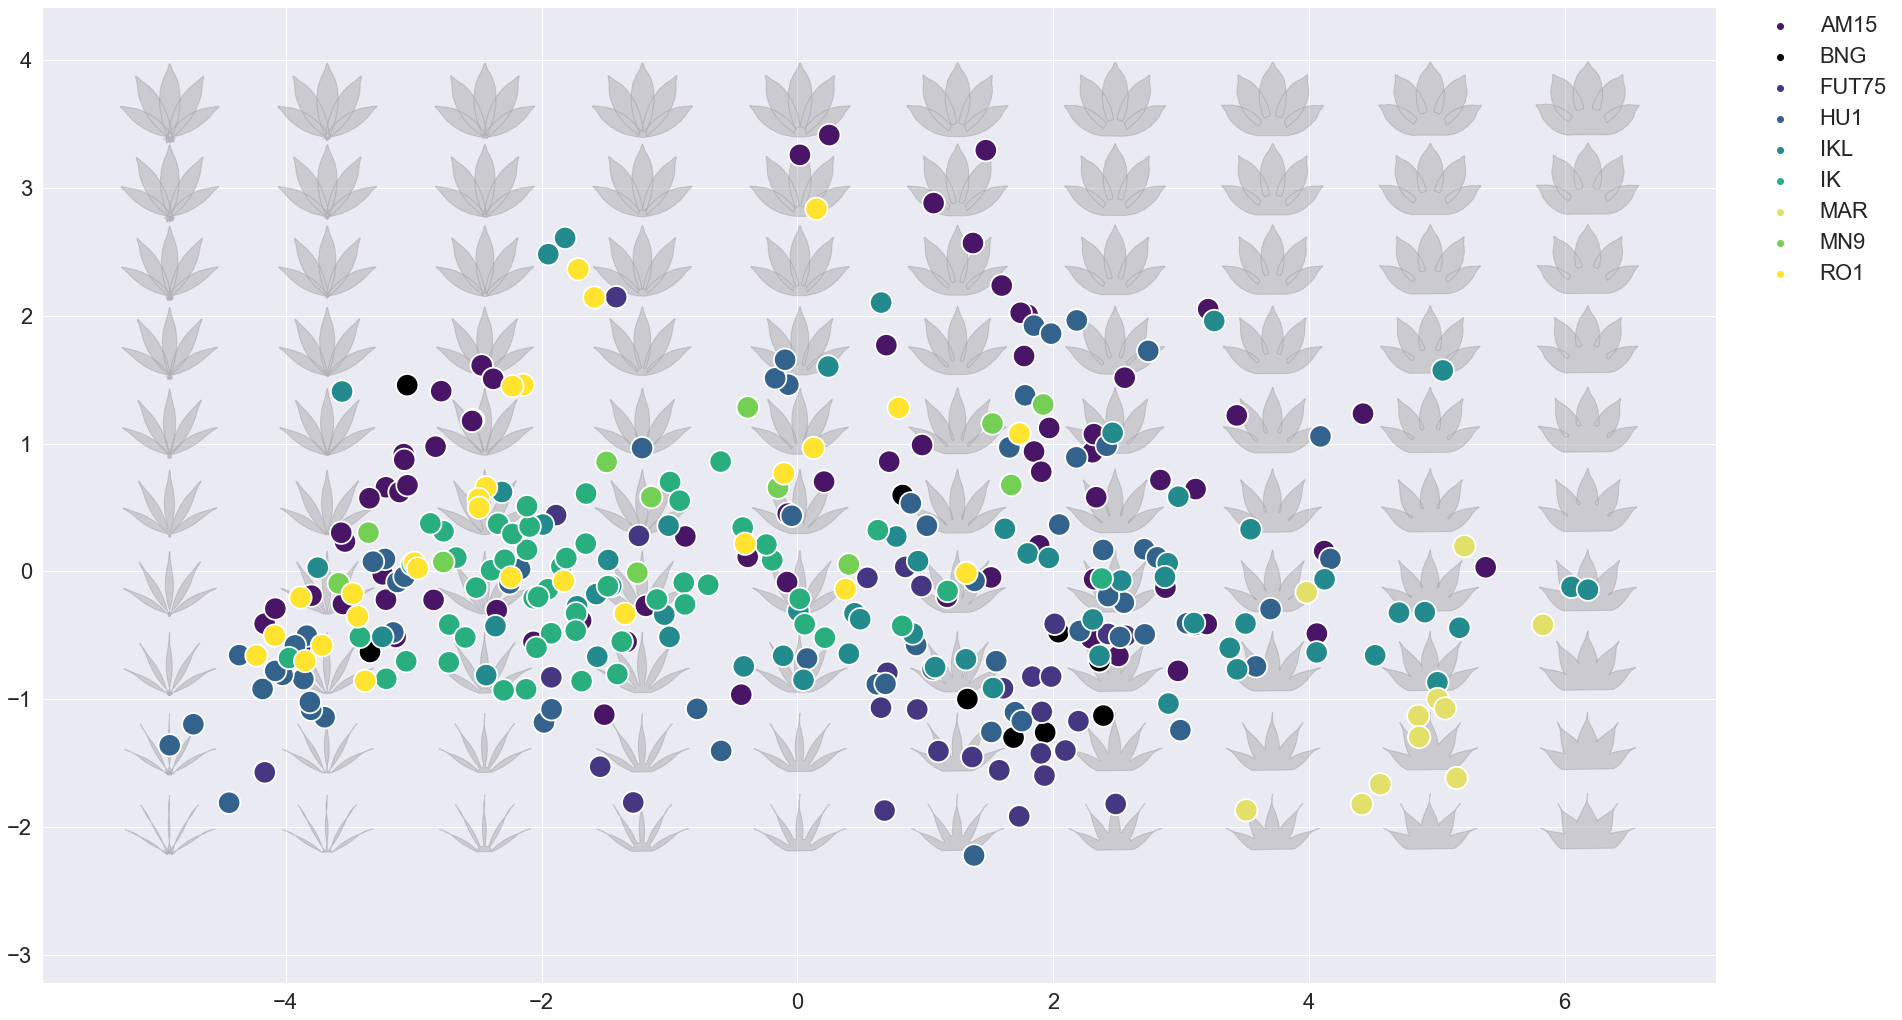

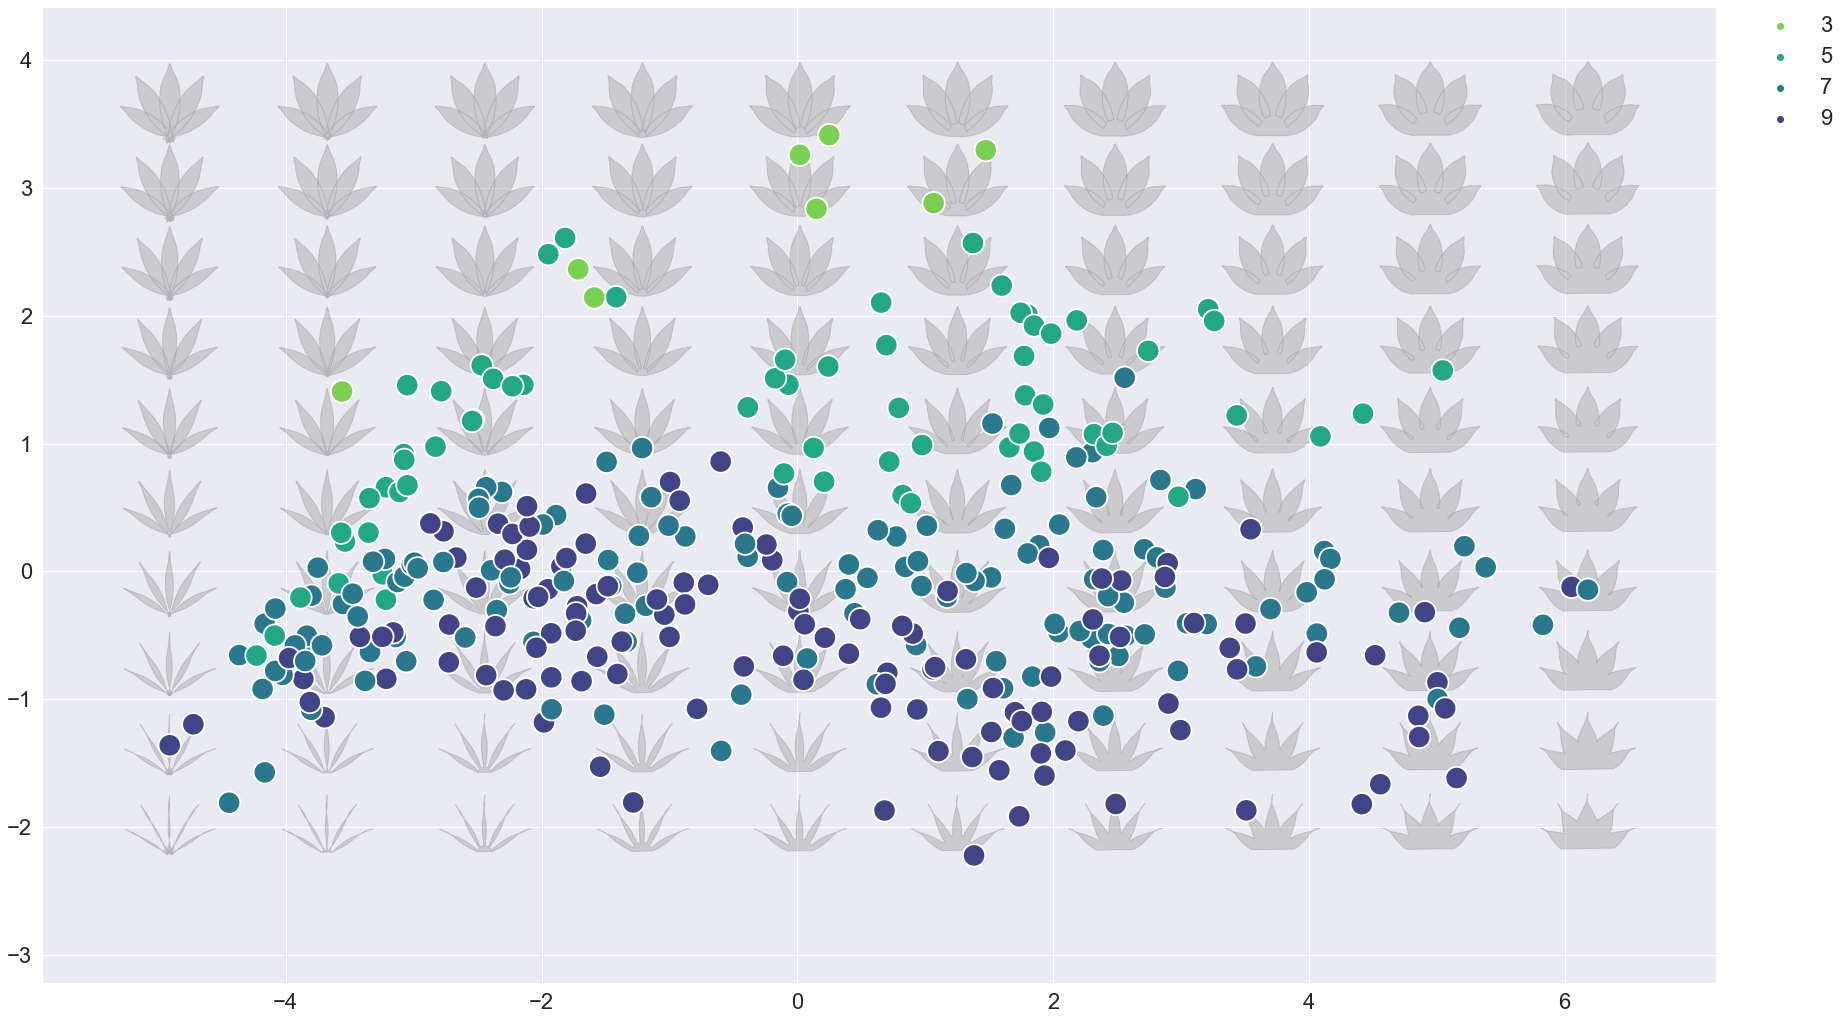

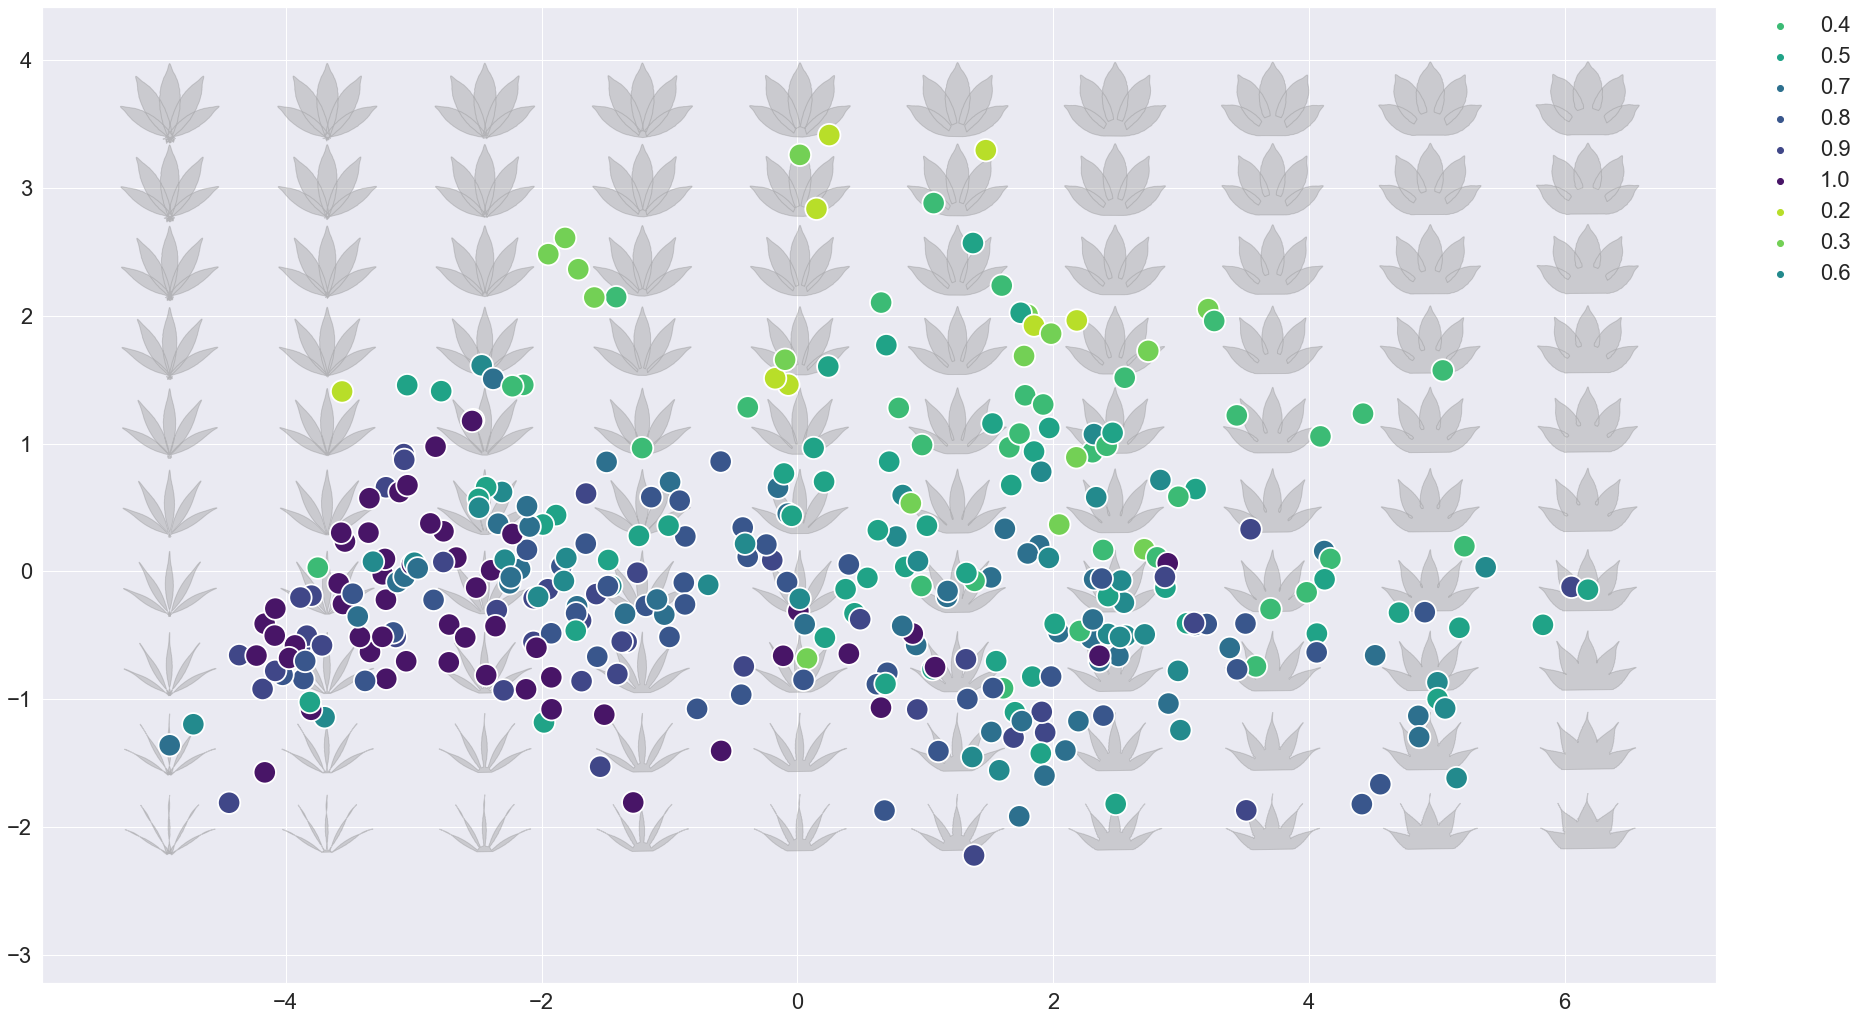

In [33]:
#################################################################
#################### SET PARAMETERS AND PLOT ####################
#################################################################

# scale, determined by checking, to prevent shape overlap
scale = 0.54

# padding on each side of PC to add extra space to see morphospace
PC1_pad = 1
PC2_pad = 1

# number of intervals to divide each PC axis
num_intervals = 10

# set the relative scale of text in the plot
sns.set(font_scale=2)

# set the datapoint size
pt_size = 500 

# FACTORS TO COLOR SCATTERPLOT BY
# pop_list = population
# ind_list = individual
# tot_list = total leaf number
# nod_list = node number
# rel_list = relative node value
# relnod_list = relative node value as categorical variable
# lob_list = lobe number

# ACCESSION PLOT
# set figure size
plt.figure(figsize=(30,20))
# apply morphospace function
Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs)
#define color factor
color_factor = pop_list
#define palette
palette_pop=("#481567", "#000000", "#453781", "#33638d", "#238a8d", "#29af7f", "#e2e068", "#73d055", "#ffe32e")
# plot the scatter plot
sns.scatterplot(x=PCs[:,0], y=PCs[:,1], hue=color_factor, s=pt_size, palette=palette_pop)
# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
# save the figure if you want
#plt.savefig("morpho_acc.pdf", format="pdf")

# LEAFLET PLOT
# set figure size
plt.figure(figsize=(30,20))
# apply morphospace function
Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs)
#define color factor
color_factor = lob_list
#define palette
palette_lob=sns.color_palette("viridis_r", 4)
# plot the scatter plot
sns.scatterplot(x=PCs[:,0], y=PCs[:,1], hue=color_factor, s=pt_size, palette=palette_lob)
# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
# save the figure if you want
#plt.savefig("morpho_leaflet.pdf", format="pdf")

# RELATIVE NODE PLOT
# set figure size
plt.figure(figsize=(30,20))
# apply morphospace function
Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs)
#define color factor
color_factor = relnod_list
#define palette
palette_relnod=("#3cbb75", "#20a387", "#2d708e", "#39568c","#404788", "#481567","#b8de29", "#73d055", "#238a8d")
# plot the scatter plot
sns.scatterplot(x=PCs[:,0], y=PCs[:,1], hue=color_factor, s=pt_size, palette=palette_relnod)
# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False);
# save the figure if you want
#plt.savefig("morpho_relative_node.pdf", format="pdf")


In [12]:
#######################################################
#################### FIND OUTLIERS ####################
#######################################################

# first, convert the list of names to an array
cannabis_arr = np.array(cannabis_leaves)

# example: find all leaves with PC2 value greater than 2
print("leaves greater than PC2 = 2", cannabis_arr[PCs[:,1]>2])


leaves greater than PC2 = 2 ['AM15_4_10_2a_3.txt' 'AM15_4_10_2b_3.txt' 'AM15_4_10_3b_5.txt'
 'AM15_5_9_2a_3.txt' 'AM15_5_9_3a_3.txt' 'AM15_6_10_3a_5.txt'
 'AM15_7_12_4a_5.txt' 'AM15_7_12_5a_5.txt' 'AM15_7_12_5b_5.txt'
 'FUT75_3_12_4a_5.txt' 'IKL_1_11_3a_5.txt' 'IKL_1_11_3b_5.txt'
 'IKL_2_9_3b_5.txt' 'RO1_3_11_2a_3.txt' 'RO1_3_11_3a_3.txt'
 'RO1_3_11_3b_3.txt']


In [13]:
# Extract the PC1 and PC2
PC1 = test_PCs[:, 0]
PC2 = test_PCs[:, 1]
acc=pop_list 
relnd=relnod_list 
lobe=lob_list

# make a dataframe
data = pd.DataFrame({'PC1': PC1, 'PC2': PC2, 'Acc': acc, 'Rel': relnd, 'Lobe': lobe })

In [14]:
# mask population levels
AM15_PC1 = data["PC1"][data["Acc"]=="AM15"]
BNG_PC1 = data["PC1"][data["Acc"]=="BNG"]
FUT75_PC1 = data["PC1"][data["Acc"]=="FUT75"]
HU1_PC1 = data["PC1"][data["Acc"]=="HU1"]
IKL_PC1 = data["PC1"][data["Acc"]=="IKL"]
IK_PC1 = data["PC1"][data["Acc"]=="IK"]
MAR_PC1 = data["PC1"][data["Acc"]=="MAR"]
MN9_PC1 = data["PC1"][data["Acc"]=="MN9"]
RO1_PC1 = data["PC1"][data["Acc"]=="RO1"]

AM15_PC2 = data["PC2"][data["Acc"]=="AM15"]
BNG_PC2 = data["PC2"][data["Acc"]=="BNG"]
FUT75_PC2 = data["PC2"][data["Acc"]=="FUT75"]
HU1_PC2 = data["PC2"][data["Acc"]=="HU1"]
IKL_PC2 = data["PC2"][data["Acc"]=="IKL"]
IK_PC2 = data["PC2"][data["Acc"]=="IK"]
MAR_PC2 = data["PC2"][data["Acc"]=="MAR"]
MN9_PC2 = data["PC2"][data["Acc"]=="MN9"]
RO1_PC2 = data["PC2"][data["Acc"]=="RO1"]

# Kruskal-Wallis test
print("Kruskal-Wallis test for accession~PC1:", stats.kruskal(AM15_PC1, BNG_PC1, FUT75_PC1, HU1_PC1, IKL_PC1, IK_PC1, MAR_PC1, MN9_PC1, RO1_PC1))
print("Kruskal-Wallis test for accession~PC2:",stats.kruskal(AM15_PC2, BNG_PC2, FUT75_PC2, HU1_PC2, IKL_PC2, IK_PC2, MAR_PC2, MN9_PC2, RO1_PC2))

Kruskal-Wallis test for accession~PC1: KruskalResult(statistic=78.60220787182107, pvalue=9.340318596681012e-14)
Kruskal-Wallis test for accession~PC2: KruskalResult(statistic=84.43096696765087, pvalue=6.244866631058519e-15)


In [15]:
# mask lobe levels
L3_PC1 = data["PC1"][data["Lobe"]==3]
L5_PC1 = data["PC1"][data["Lobe"]==5]
L7_PC1 = data["PC1"][data["Lobe"]==7]
L9_PC1 = data["PC1"][data["Lobe"]==9]

L3_PC2 = data["PC2"][data["Lobe"]==3]
L5_PC2 = data["PC2"][data["Lobe"]==5]
L7_PC2 = data["PC2"][data["Lobe"]==7]
L9_PC2 = data["PC2"][data["Lobe"]==9]

# Kruskal-Wallis test
print("Kruskal-Wallis test for lobe~PC1:", stats.kruskal(L3_PC1, L5_PC1, L7_PC1, L9_PC1))
print("Kruskal-Wallis test for lobe~PC2:",stats.kruskal(L3_PC2, L5_PC2, L7_PC2, L9_PC2))

Kruskal-Wallis test for lobe~PC1: KruskalResult(statistic=1.2709880531066347, pvalue=0.7360335049124791)
Kruskal-Wallis test for lobe~PC2: KruskalResult(statistic=156.15786802048092, pvalue=1.236592744015671e-33)


In [16]:
# mask relative node levels
R2_PC1 = data["PC1"][data["Rel"]=="0.2"]
R3_PC1 = data["PC1"][data["Rel"]=="0.3"]
R4_PC1 = data["PC1"][data["Rel"]=="0.4"]
R5_PC1 = data["PC1"][data["Rel"]=="0.5"]
R6_PC1 = data["PC1"][data["Rel"]=="0.6"]
R7_PC1 = data["PC1"][data["Rel"]=="0.7"]
R8_PC1 = data["PC1"][data["Rel"]=="0.9"]
R9_PC1 = data["PC1"][data["Rel"]=="0.9"]
R10_PC1 = data["PC1"][data["Rel"]=="1.0"]

R2_PC2 = data["PC2"][data["Rel"]=="0.2"]
R3_PC2 = data["PC2"][data["Rel"]=="0.3"]
R4_PC2 = data["PC2"][data["Rel"]=="0.4"]
R5_PC2 = data["PC2"][data["Rel"]=="0.5"]
R6_PC2 = data["PC2"][data["Rel"]=="0.6"]
R7_PC2 = data["PC2"][data["Rel"]=="0.7"]
R8_PC2 = data["PC2"][data["Rel"]=="0.9"]
R9_PC2 = data["PC2"][data["Rel"]=="0.9"]
R10_PC2 = data["PC2"][data["Rel"]=="1.0"]

# Kruskal-Wallis test
print("Kruskal-Wallis test for relative node~PC1:", stats.kruskal(R2_PC1, R3_PC1, R4_PC1, R5_PC1, R6_PC1, R7_PC1, R8_PC1, R9_PC1, R10_PC1))
print("Kruskal-Wallis test for relative node~PC2:", stats.kruskal(R2_PC2, R3_PC2, R4_PC2, R5_PC2, R6_PC2, R7_PC2, R8_PC2, R9_PC2, R10_PC2))

Kruskal-Wallis test for relative node~PC1: KruskalResult(statistic=91.21435653860883, pvalue=2.6355379107168127e-16)
Kruskal-Wallis test for relative node~PC2: KruskalResult(statistic=101.3529425717412, pvalue=2.257924207151616e-18)


## Visualize leaves 

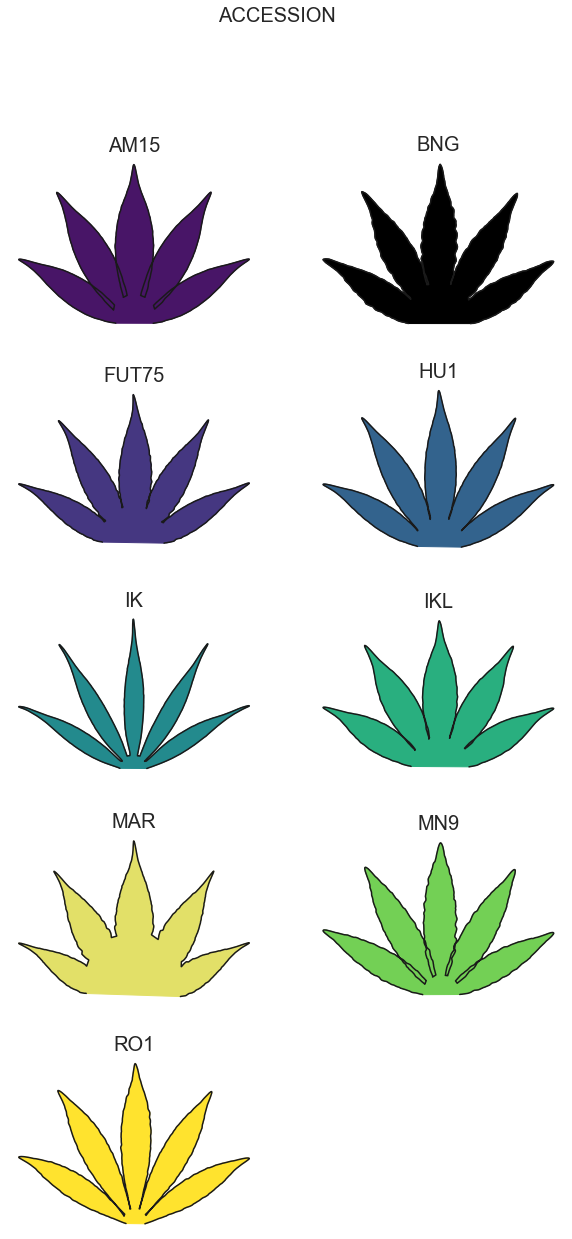

In [34]:
##########################
###### BY ACCESSION ######
##########################

# convert list to arr
pop_arr = np.array(pop_list)

# get unique factor levels to plot
pop_names = np.unique(pop_arr)

# set figure size
plt.figure(figsize=(10,20))

# parameters
fs = 20
plot_colors = ["#481567", "#000000", "#453781", "#33638d", "#238a8d", "#29af7f", "#e2e068", "#73d055", "#ffe32e"]
outline_col = "k"

for i in range(len(pop_names)):

    # get current pop to plot
    curr_pop = pop_names[i]

    # mask pop to plot
    pop_vals = theor_arr[pop_arr==curr_pop]

    # get mean vals
    pop_mean = np.mean(pop_vals, axis=0)

    # get x and y vals
    popx = pop_mean[0:int(len(pop_mean)/2)]
    popy = pop_mean[int(len(pop_mean)/2):]

    # plot
    plt.subplot(5,2,i+1)
    plt.plot(-popx, -popy, c=outline_col)
    plt.fill(-popx, -popy, c=plot_colors[i])
    plt.title(curr_pop, fontsize=fs)
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
plt.suptitle("ACCESSION", fontsize=fs);

#plt.savefig("plot_ACCESSION.pdf", format="pdf")

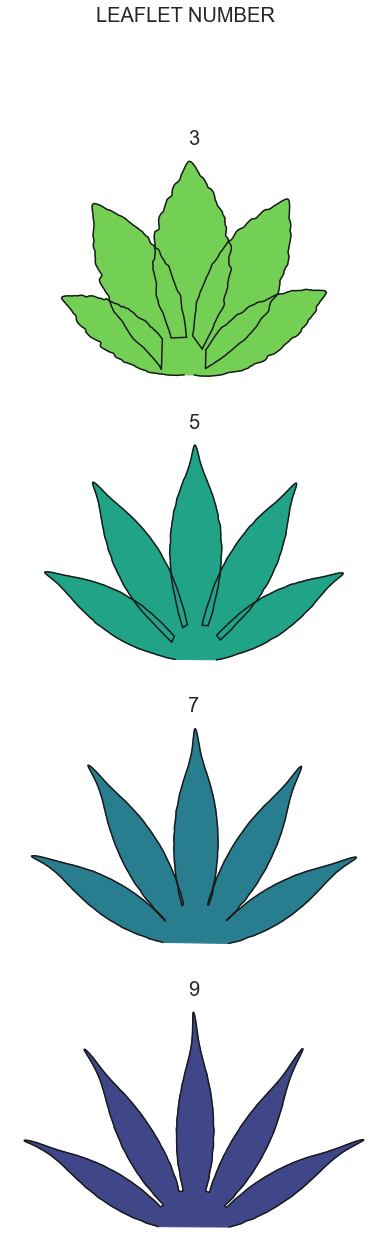

In [35]:
############################
###### BY LEAFLET NUMBER ######
############################

## convert lobe number to string
lob_str = [str(x) for x in lob_list]

# convert list to arr
lob_arr = np.array(lob_str)

# get unique factor levels to plot
lob_names = np.unique(lob_arr)

# set figure size
plt.figure(figsize=(10,20))

# parameters
fs = 20
plot_colors = ["#73d055", "#20a387", "#287d8e", "#404788"]
outline_col = "k"

for i in range(len(lob_names)):

    # get current lob to plot
    curr_lob = lob_names[i]

    # mask lobe number to plot
    lob_vals = theor_arr[lob_arr==curr_lob]

    # get mean vals
    lob_mean = np.mean(lob_vals, axis=0)

    # get x and y vals
    lobx = lob_mean[0:int(len(lob_mean)/2)]
    loby = lob_mean[int(len(lob_mean)/2):]

    # plot
    plt.subplot(4,1,i+1)
    plt.plot(-lobx, -loby, c=outline_col)
    plt.fill(-lobx, -loby, c=plot_colors[i])
    plt.title(curr_lob, fontsize=fs)
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
plt.suptitle("LEAFLET NUMBER", fontsize=fs);

#plt.savefig("plot_LEAFLETNUMBER.pdf", format="pdf")

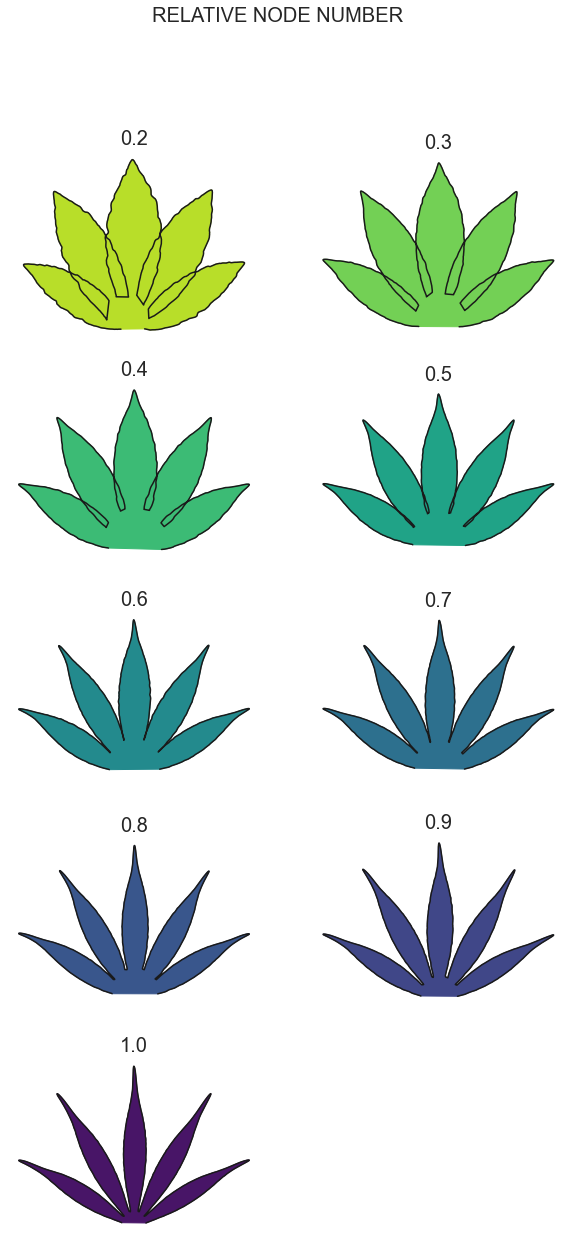

In [32]:
#####################################
###### BY RELATIVE NODE NUMBER ######
#####################################

# convert list to arr
rel_arr = np.array(relnod_list)

# get unique factor levels to plot
rel_names = np.unique(rel_arr)

# set figure size
plt.figure(figsize=(10,20))

# parameters
fs = 20
plot_color = ["#b8de29", "#73d055", "#3cbb75","#20a387", "#238a8d", "#2d708e", "#39568c","#404788", "#481567"]
outline_col = "k"

for i in range(len(rel_names)):

    # get current relative node to plot
    curr_rel = rel_names[i]

    # mask relative node to plot
    rel_vals = theor_arr[rel_arr==curr_rel]

    # get mean vals
    rel_mean = np.mean(rel_vals, axis=0)

    # get x and y vals
    relx = rel_mean[0:int(len(rel_mean)/2)]
    rely = rel_mean[int(len(rel_mean)/2):]

    # plot
    plt.subplot(5,2,i+1)
    plt.plot(-relx, -rely, c=outline_col)
    plt.fill(-relx, -rely, c=plot_color[i])
    plt.title(curr_rel, fontsize=fs)
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
plt.suptitle("RELATIVE NODE NUMBER", fontsize=fs);

#plt.savefig("plot_RELATIVENODE.pdf", format="pdf")

# LINEAR DISCRIMINANT ANALYSIS

## By accession

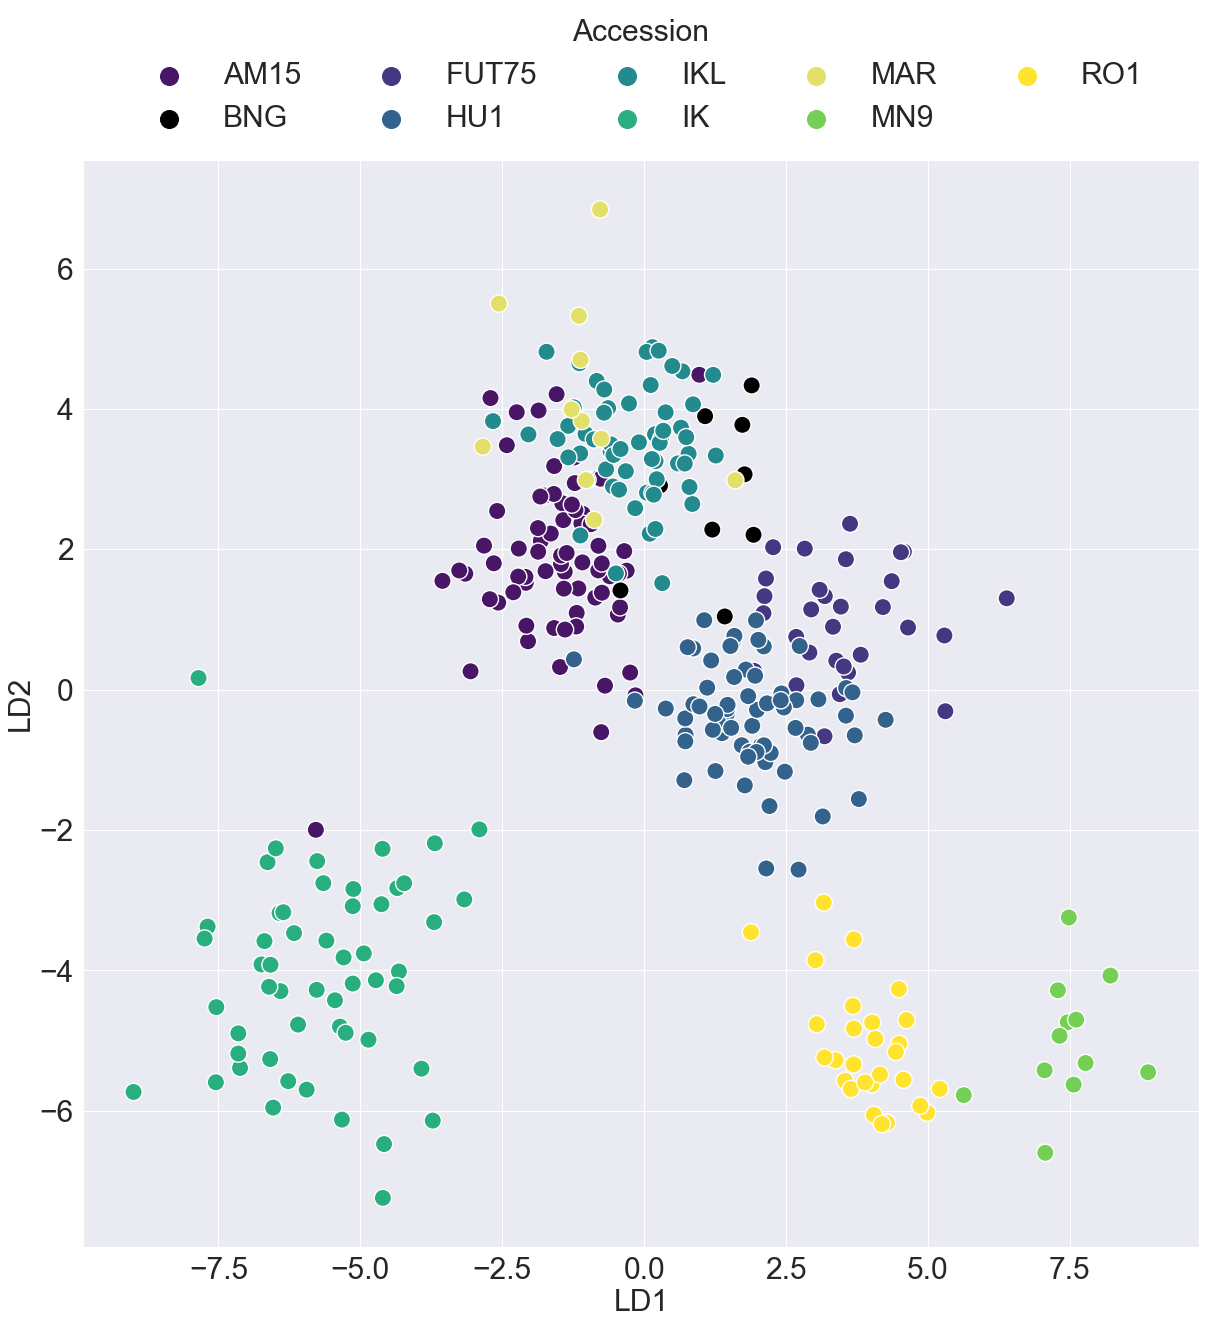

In [20]:
## x is the features we use to predict factor
## they are the modeled x and y coordinate values
x_pop = theor_arr

## y is the factor we are predicting
## in this case it is population
y_pop = pop_list

## we create an LDA model for population from coordiate values
## and then we fit the model
pop_model = LinearDiscriminantAnalysis()
pop_model.fit(x_pop, y_pop)

## calculate the LDs from the model
pop_LDs = pop_model.fit(x_pop, y_pop).transform(x_pop)

## create a df to plot the data
popLD_df = pd.DataFrame({'LD1':pop_LDs[:,0], 
                      'LD2':pop_LDs[:,1], 
                      'pop':pop_list})

## define the palette
palette_pop=("#481567", "#000000", "#453781", "#33638d", "#238a8d", "#29af7f", "#e2e068", "#73d055", "#ffe32e")

## define figure size
plt.figure(figsize=(20,20))

## plot
ax=sns.scatterplot(data=popLD_df, x="LD1", y="LD2", hue="pop", s=300, palette=palette_pop, legend=True)
ax.tick_params(labelsize=30)
ax.set_xlabel("LD1", fontsize=30)
ax.set_ylabel("LD2", fontsize=30)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), fontsize= 30, ncol=5, 
                markerscale=3, title="Accession", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize='30') 
#plt.savefig("LDA_acc.pdf", format="pdf")
plt.show()


## By leaflet number

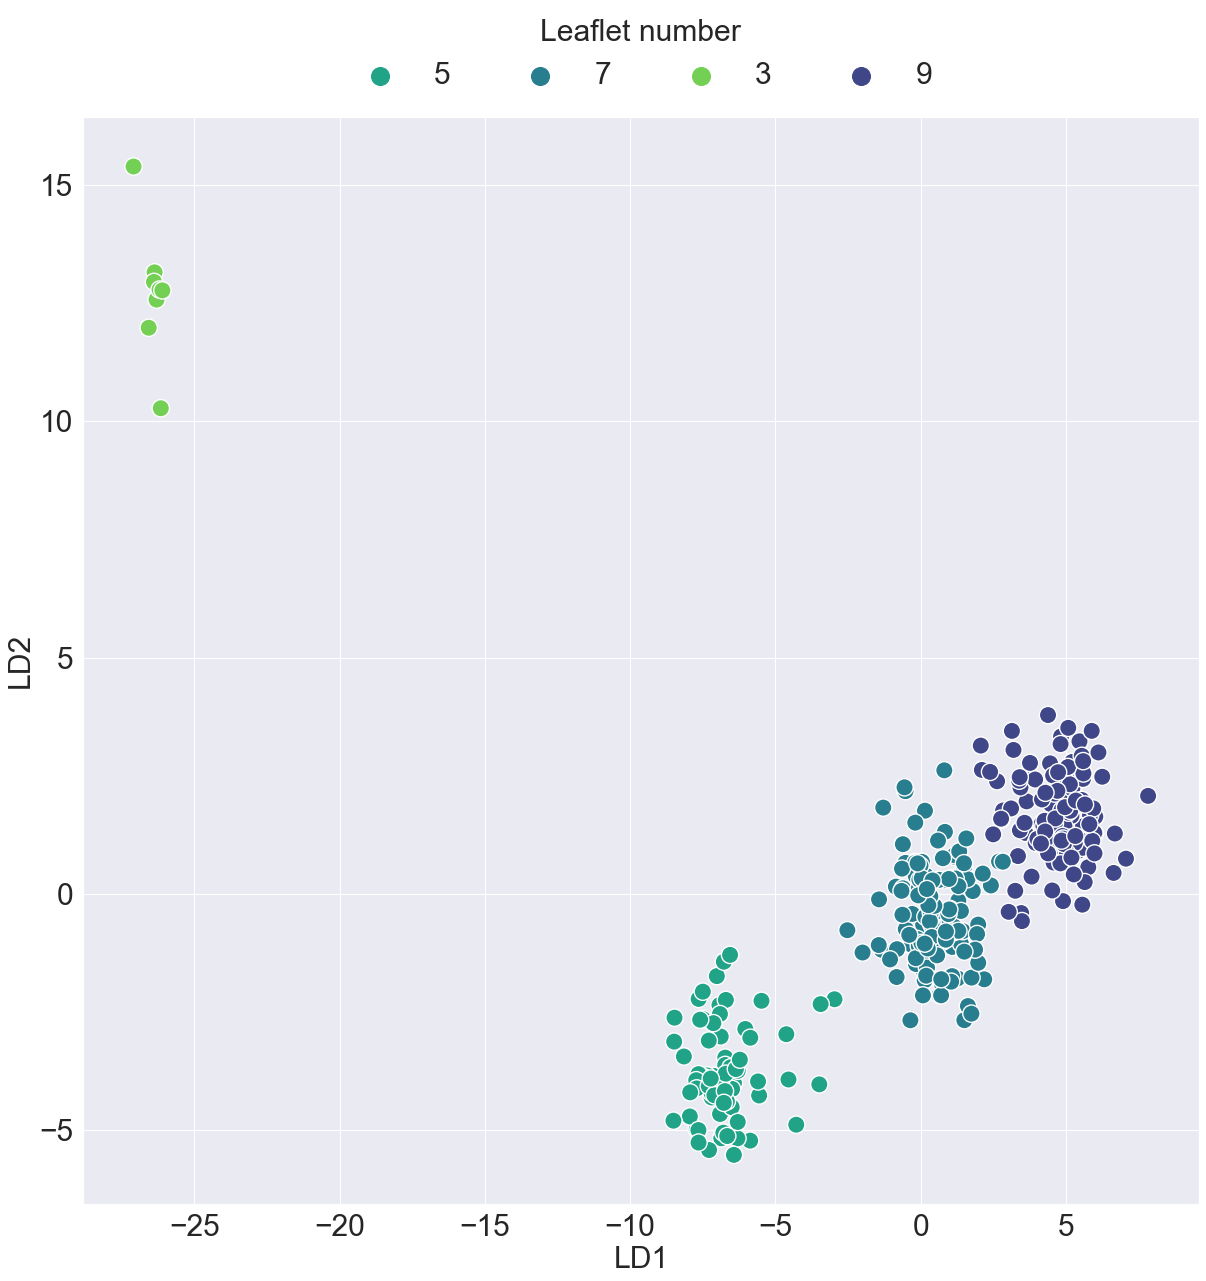

In [21]:
## x is the features we use to predict factor
## they are the modeled x and y coordinate values
x_lob = theor_arr

## y is the factor we are predicting
## in this case it is lobe number
## convert lobe number to string
y_lob = [str(x) for x in lob_list]

## we create an LDA model for lobe number from coordiate values
## and then we fit the model
lob_model = LinearDiscriminantAnalysis()
lob_model.fit(x_lob, y_lob)

## calculate the LDs from the model
lob_LDs = lob_model.fit(x_lob, y_lob).transform(x_lob)

## create a df to plot the data
lobLD_df = pd.DataFrame({'LD1':lob_LDs[:,0], 
                      'LD2':lob_LDs[:,1], 
                      'lob':y_lob})

## Define the palette
palette_lob=("#20a387", "#287d8e", "#73d055", "#404788")

## Define the figure size
plt.figure(figsize=(20,20))

## Plot
ax=sns.scatterplot(data=lobLD_df, x="LD1", y="LD2", hue="lob", s=300, palette=palette_lob, legend=True)
ax.tick_params(labelsize=30)
ax.set_xlabel("LD1", fontsize=30)
ax.set_ylabel("LD2", fontsize=30)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), fontsize= 30, ncol=4, 
                markerscale=3, title="Leaflet number", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize='30') 
#plt.savefig("LDA_leaflet.pdf", format="pdf")
plt.show()

## By relative node

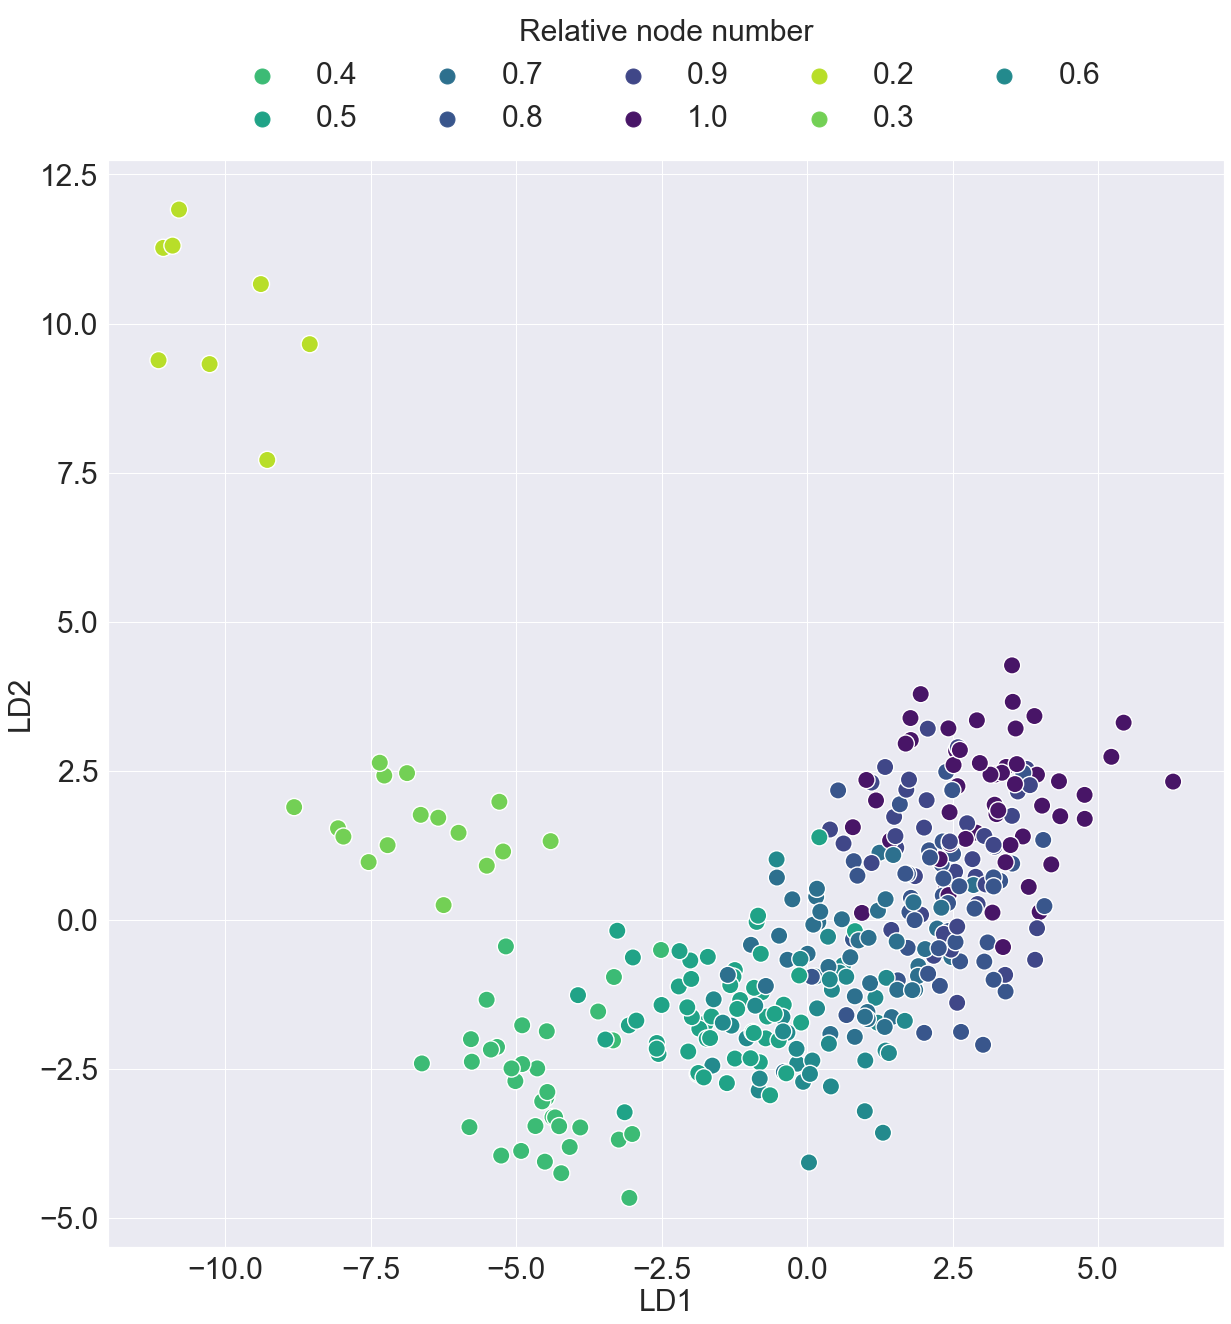

In [22]:
## x is the features we use to predict factor
## they are the modeled x and y coordinate values
x_rel = theor_arr

## y is the factor we are predicting
## in this case it is relative node number
y_rel = relnod_list

## we create an LDA model for relative node number from coordiate values
## and then we fit the model
rel_model = LinearDiscriminantAnalysis()
rel_model.fit(x_rel, y_rel)

## calculate the LDs from the model
rel_LDs = rel_model.fit(x_rel, y_rel).transform(x_rel)

## create a df to plot the data
relLD_df = pd.DataFrame({'LD1':rel_LDs[:,0], 
                      'LD2':rel_LDs[:,1], 
                      'rel':y_rel})

## Define the palette
palette_rel_node=("#3cbb75", "#20a387", "#2d708e", "#39568c","#404788", "#481567","#b8de29", "#73d055", "#238a8d")

## Define the figure size
plt.figure(figsize=(20,20))

## Plot
ax=sns.scatterplot(data=relLD_df, x="LD1", y="LD2", hue="rel", s=300, palette=palette_rel_node, legend=True)
ax.tick_params(labelsize=30)
ax.set_xlabel("LD1", fontsize=30)
ax.set_ylabel("LD2", fontsize=30)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), fontsize= 30, ncol=5, 
                markerscale=2.5, title="Relative node number", frameon=False)
plt.setp(ax.get_legend().get_title(), fontsize='30') 
#plt.savefig("LDA_rel.pdf", format="pdf")
plt.show()

# PREDICTION ON TRAIN (a) AND TEST (b) DATASETS

In [23]:
# Extract the indexes of where leaves with a and c and leaves with b and d are found and save them in a new list of 
# indexes for leaves ind_a and ind_b and check the length

def find_ac(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch or ltr == 'c']

def find_bd(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch or ltr == 'd']

    
leaf_a = find_ac(nodab_list, "a")
leaf_b = find_bd(nodab_list, "b")
#print(len(nodab_list))
#print(len(leaf_a))
#print(len(leaf_b))
#print(len(leaf_a) + len(leaf_b))

In [24]:
## Extract the rows with the x and y coordinate values for with leaves a and b into a separate array.
new_arr_a = theor_arr[leaf_a]
new_arr_b = theor_arr[leaf_b]

## Check the new structures of lists and arrays to make sure :)
#print(len(leaf_a), len(leaf_b))
#print(len(new_arr_a), len(new_arr_b))    
#print(type(new_arr_a), type(new_arr_b) 
#print(new_arr_a.shape, new_arr_b.shape)

In [25]:
# Then we need to extract the data from the lists we will use as y test dataset

pop_list_a = [pop_list[i] for i in leaf_a]
pop_list_b = [pop_list[i] for i in leaf_b]
#print(len(pop_list_a), len(pop_list_b)) 

relnod_list_a = [relnod_list[i] for i in leaf_a]
relnod_list_b = [relnod_list[i] for i in leaf_b]
#print(len(relnod_list_a), len(relnod_list_b)) 

lob_list_a = [lob_list[i] for i in leaf_a]
lob_list_b = [lob_list[i] for i in leaf_b]
#print(len(lob_list_a), len(lob_list_b)) 

## Train the model on a and predict the b leaves and plot confusion matrix

## By accession

Count of True values for accession: 120
Count of False values for accession: 42


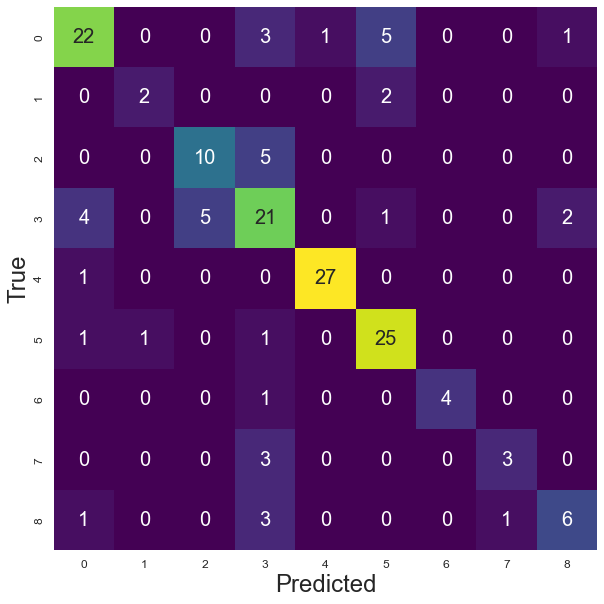

In [36]:
## x is the features we use to predict factor
## they are the modeled x and y coordinate values
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting
## in this case it is population
y_a = pop_list_a
y_b = pop_list_b

## we create an LDA model for population from coordiate values
## and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_pop= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_pop)]

count_true = comparison_result.count(True)
count_false = comparison_result.count(False)
print("Count of True values for accession:", count_true)
print("Count of False values for accession:", count_false)

## Plot a confusion matrix

# True values
true_values = pop_list_b

# Predicted values
predicted_values = prediction_pop

# Create confusion matrix
cm = confusion_matrix(true_values, predicted_values)
# Create heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": 20}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
#plt.savefig("confusion_accession.pdf", format="pdf")

## By leaflet

Count of True values for leaflet number: 150
Count of False values for leaflet number: 12


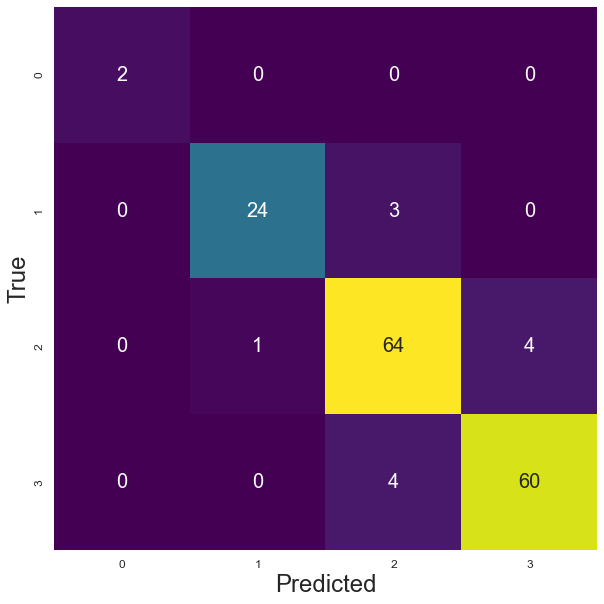

In [37]:
## x is the features we use to predict factor
## they are the modeled x and y coordinate values
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting
## in this case it is population
y_a = lob_list_a
y_b = lob_list_b

## we create an LDA model for population from coordiate values
## and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_lob= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_lob)]

count_true = comparison_result.count(True)
count_false = comparison_result.count(False)
print("Count of True values for leaflet number:", count_true)
print("Count of False values for leaflet number:", count_false)


## Plot a confusion matrix

# True values
true_values = lob_list_b

# Predicted values
predicted_values = prediction_lob

# Create confusion matrix
cm = confusion_matrix(true_values, predicted_values)
# Create heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": 20}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
#plt.savefig("confusion_leaflet.pdf", format="pdf")

## By relative node

Count of True values for relative node: 51
Count of False values for relative node: 111


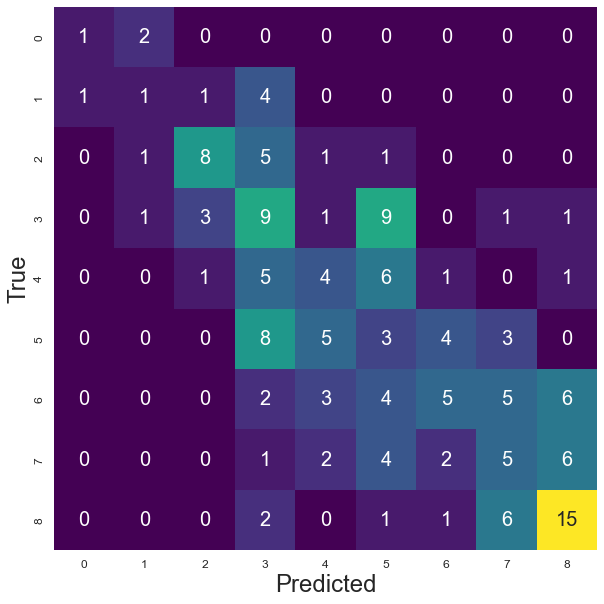

In [38]:
## x is the features we use to predict factor
## they are the modeled x and y coordinate values
x_a = new_arr_a
x_b = new_arr_b

## y is the factor we are predicting
## in this case it is population
y_a = relnod_list_a
y_b = relnod_list_b

## we create an LDA model for population from coordiate values
## and then we fit the model
model = LinearDiscriminantAnalysis()
model.fit(x_a, y_a)
prediction_relnod= model.predict(x_b)

comparison_result = [x == y for x, y in zip(y_b, prediction_relnod)]

count_true = comparison_result.count(True)
count_false = comparison_result.count(False)
print("Count of True values for relative node:", count_true)
print("Count of False values for relative node:", count_false)


## Plot a confusion matrix

# True values
true_values = relnod_list_b

# Predicted values
predicted_values = prediction_relnod

# Create confusion matrix
cm = confusion_matrix(true_values, predicted_values)
# Create heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", square=True, annot_kws={"fontsize": 20}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
#plt.savefig("confusion_rel_node.pdf", format="pdf")

In [29]:
#calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(relnod_list_b, prediction_relnod)

#print Spearman rank correlation and p-value
print(rho)
print(p)

0.7291356040320062
3.8066271701251607e-28
